In [74]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = "{:,.2f}".format

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from ast import literal_eval

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/francotestori/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/francotestori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Review Analysis by Course

In [75]:
REVIEW_COMMENT_COUNT_FILTER=250

In [76]:
df_udemy = pd.read_csv(
    f'udemy_reviews.zip',
    compression='zip',
    header=0,
    sep=',',
    quotechar='"'
)

df_udemy.head(3)

,id,course,rating,comment,user
0,73015398,1640654,2.50,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,Jorge Alejandro Castillo
1,50586814,1640654,4.50,Los conocimientos son claros y concisos para lo requerido,Jaime Medina
2,49880684,1640654,5.00,hermoso,Adrián Antonio Herrera Castro


In [77]:
df_course = df_udemy.groupby(['course'])\
    .agg({
        'rating': 'mean',
        'id': 'count'
    })\
    .rename(
        columns= {'id': 'reviews', 'rating': 'mean_rating'}
    )\
    .reset_index()

# We filter courses with at least 100 reviews
df_course = df_course.loc[df_course.reviews >= REVIEW_COMMENT_COUNT_FILTER,]

df_course

,course,mean_rating,reviews
30,78104,4.43,649
33,81450,4.48,271
43,97280,4.71,648
48,101866,4.56,578
54,120058,4.17,544
...,...,...,...
3022,2915362,4.73,750
3158,3013160,4.84,283
3712,3372986,4.95,280
3853,3446356,4.59,396


{'whiskers': [<matplotlib.lines.Line2D at 0x1462a5370>,
 'caps': [<matplotlib.lines.Line2D at 0x144349430>,
 'boxes': [<matplotlib.lines.Line2D at 0x1462a5a30>],
 'medians': [<matplotlib.lines.Line2D at 0x14585caf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x14585cf10>],
 'means': []}

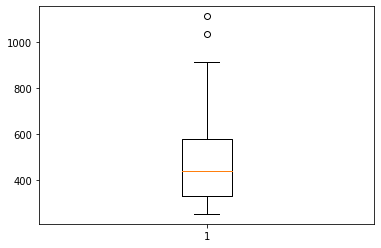

In [78]:
plt.boxplot(df_course.reviews)

In [79]:
def _discrete_avg_rating(row):
    rating = row['mean_rating']
    if rating > 4.75:
        value = 5.0
    elif 4.75 >= rating > 4.25:
        value = 4.5
    elif 4.25 >= rating > 3.75:
        value = 4.0
    elif 3.75 >= rating > 3.25:
        value = 3.5
    elif 3.25 >= rating > 2.75:
        value = 3.0
    elif 2.75 >= rating > 2.25:
        value = 2.5
    elif 2.25 >= rating > 1.75:
        value = 2.0
    elif 1.75 >= rating > 1.25:
        value = 1.5
    elif 1.25 >= rating > 0.75:
        value = 1.0
    elif 0.75 >= rating > 0.25:
        value = 0.5
    else:
        value = 0.0

    return value

df_course['rating_label'] = df_course.apply(_discrete_avg_rating, axis=1)
df_course.sort_values(by=['mean_rating'], ascending=False)

,course,mean_rating,reviews,rating_label
2936,2851496,4.96,436,5.00
3712,3372986,4.95,280,5.00
1120,1562070,4.90,487,5.00
1396,1754560,4.88,567,5.00
1237,1651564,4.88,531,5.00
...,...,...,...,...
238,498976,4.01,428,4.00
2527,2579252,3.98,290,4.00
2295,2437520,3.82,313,4.00
774,1288270,3.80,343,4.00


In [80]:
df_course.rating_label\
    .value_counts()\
    .reset_index()\
    .rename(columns={'rating_label': 'courses'})\
    .rename(columns={'index': 'rating_label'})\
    .sort_values(
        by=['rating_label'],
        ascending=False
    )


,rating_label,courses
1,5.00,23
0,4.50,141
2,4.00,14
3,3.50,1


We end up having 1381 courses, distributed among rating labels from 2.5 to 5.0.

In [81]:
df_courses_reviews = pd.merge(
    df_udemy,
    df_course.loc[:,['course', 'mean_rating']],
    on=['course'],
    how='inner'
)

df_courses_reviews.head(3)

,id,course,rating,comment,user,mean_rating
0,95458295,1698124,5.00,Fácil de entender,Patricia de las Mercedes Muñoz Alvarado,4.65
1,95451111,1698124,5.00,"Fue una muy buena elección la que hice. El tema está muy bien explicado, conciso y estructurado.",Leidy Castrillon,4.65
2,95195366,1698124,5.00,El curso es recomendable. El profesor es claro en la explicación y sigue un orden lógico en el contenido.,Adrian Gillotta,4.65


In [82]:
df_courses_reviews.index.unique().size

84723

The 1381 courses, have a total number of 164420 reviews (we only use courses with at least 10 reviews for our analysis).

## Preprocessing

In [83]:
# Add Review TAG
df_courses_reviews['tag'] = df_courses_reviews.rating.apply(lambda rating: 'pos' if rating >= 4 else 'neg')

# Filter comments with less than 5 words
df_courses_reviews = df_courses_reviews[df_courses_reviews['comment'].str.split().str.len().gt(4)]
# Filter comments with less than 12 characters (e.g: "Excelente!")
df_news = df_courses_reviews[df_courses_reviews['comment'].str.len() >= 12]

df_courses_reviews.head(3)

,id,course,rating,comment,user,mean_rating,tag
1,95451111,1698124,5.00,"Fue una muy buena elección la que hice. El tema está muy bien explicado, conciso y estructurado.",Leidy Castrillon,4.65,pos
2,95195366,1698124,5.00,El curso es recomendable. El profesor es claro en la explicación y sigue un orden lógico en el contenido.,Adrian Gillotta,4.65,pos
3,94712498,1698124,3.00,Al instructor le falta algo de emocionalidad en el habla,Betsy Anciani,4.65,neg


In [84]:
review_size = df_courses_reviews.index.size
print(f'Review size {review_size}')

Review size 61850


In [85]:
df_courses_reviews.course.unique().size

179

In [86]:
df_courses_reviews['tag'].value_counts().apply(lambda x: x/ review_size )

pos   0.88
neg   0.12
Name: tag, dtype: float64

After filtering we end up having 120855 reviews.
- 14,25 % **negative**
- 85,75 % **positive**

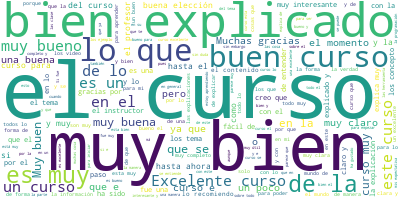

In [87]:
# Join the different processed titles together.
long_string = ','.join(
    list(df_courses_reviews['comment'].values)
)

# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=500,
    contour_width=3,
    contour_color='steelblue'
)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [88]:
from nltk.corpus import stopwords
DEFAULT_STOPWORDS = set(stopwords.words('spanish'))

CUSTOM_BLACKLIST = [
    'excelente',
    'buen',
    'bien',
    'muchas',
    'gracias',
    'curso',
    'course',
    'good'
]
CUSTOM_STOPWORDS = set(CUSTOM_BLACKLIST)

STOPWORDS = DEFAULT_STOPWORDS.union(CUSTOM_STOPWORDS)

In [89]:
import re
from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')

def stemmization(texts: str):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()

from typing import List
import spacy
nlp = spacy.load('es_core_news_md')

def lemmatization(texts: str, allowed_postags: List[str]= ['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in
                 allowed_postags and token.text not in CUSTOM_BLACKLIST and len(token.text)>2]
    return texts_out

In [90]:
import gensim

BIGRAM = gensim.models.Phrases(df_news['comment'].to_list())

def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word)
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in STOPWORDS and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in CUSTOM_BLACKLIST if string in x)]
    word = " ".join(wordlist)
    list_word_clean = []
    for w1 in word.split(r"\s"):
        if  w1.lower() not in STOPWORDS:
            list_word_clean.append(w1.lower())

    bigram_list = BIGRAM[list_word_clean]
    out_text = stemmization(" ".join(bigram_list))
    return out_text

In [91]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_courses_reviews['comment_cleaned'] = df_courses_reviews['comment'].progress_apply(cleaner)

  0%|          | 0/61850 [00:00<?, ?it/s]

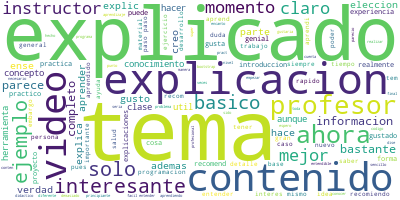

In [19]:
# Join the different processed titles together.
long_string = ','.join(
    list([' '.join(map(str, l)) for l in df_courses_reviews['comment_cleaned']])
)
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=500,
    contour_width=3,
    contour_color='steelblue'
)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens.

In [20]:
from gensim.corpora import Dictionary

DICTIONARY = Dictionary(
    df_courses_reviews['comment_cleaned'].to_list()
)
DICTIONARY.compactify()

# Filter extremes
DICTIONARY.filter_extremes(no_below=5, no_above=0.2, keep_n=None)
DICTIONARY.compactify()

CORPUS = [DICTIONARY.doc2bow(text) for text in df_courses_reviews['comment_cleaned'].to_list()]

TEXTS = df_courses_reviews['comment_cleaned'].to_list()

## Modeling

In [21]:
from gensim.models import CoherenceModel, LdaMulticore
from tqdm import tqdm_notebook

DEFAULT_SEED = 671993

def _generate_lda_model(corpus, dictionary, texts, topics, seed):
    model = LdaMulticore(
        corpus=corpus,
        workers=5,
        chunksize=2000000,
        num_topics=topics,
        id2word=dictionary,
        iterations = 2000,
        passes=10,
        random_state = seed
    )
    coherence_model = CoherenceModel(
        model=model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_value = coherence_model.get_coherence()

    return model, coherence_value

def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print (f"Topic {topic_idx}:")
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

def evaluate_graph(
        dictionary,
        corpus,
        texts,
        min_topics: int = 1,
        max_topics: int = 14,
        seed: int = DEFAULT_SEED
):
    """
    Function to display num_topics - LDA graph using c_v coherence

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in tqdm_notebook(
            range(min_topics, max_topics),
            total=max_topics - min_topics,
            desc="Evaluating graph"
    ):
        model, coherence = _generate_lda_model(
            corpus=corpus,
            dictionary=dictionary,
            texts=texts,
            topics=num_topics,
            seed=seed
        )
        lm_list.append(model)
        c_v.append(coherence)

    # Show graph
    x = range(min_topics, max_topics)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend("c_v", loc='best')
    plt.show()

    return lm_list, c_v

Evaluating graph:   0%|          | 0/39 [00:00<?, ?it/s]

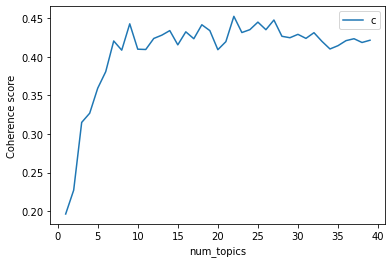

In [22]:
lda_list, c_v = evaluate_graph(
    dictionary=DICTIONARY,
    corpus=CORPUS,
    texts=TEXTS,
    min_topics=1,
    max_topics=40
)

In [23]:
import numpy as np

def evaluate_best_seed(dictionary, corpus, texts, num_topics: int):
    """
    Function to display num_topics - LDA graph using c_v coherence

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    random_seeds = np.random.randint(100000, size=30)

    cm_max=0
    lda_max=0
    seed_max=0
    lda_list=[]
    c_v = []

    for seed in tqdm_notebook(
            random_seeds,
            total=len(random_seeds),
            desc="LDA processing"
    ):
        lda_model_temp, cm_temp = _generate_lda_model(
            corpus=corpus,
            dictionary=dictionary,
            texts=texts,
            topics=num_topics,
            seed=seed
        )

        lda_list.append(lda_model_temp)
        c_v.append(cm_temp)

        if cm_temp > cm_max:
          lda_max = lda_model_temp
          seed_max = seed
          cm_max = cm_temp

    # Show graph
    x = range(
        len(random_seeds)
    )

    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend("c_v", loc='best')
    plt.show()

    return lda_max, seed_max

LDA processing:   0%|          | 0/30 [00:00<?, ?it/s]

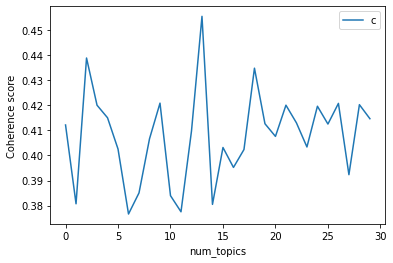

29131

In [24]:
TOPICS_NUMBER = 9

lda_best_model, best_seed = evaluate_best_seed(
    dictionary=DICTIONARY,
    corpus=CORPUS,
    texts=TEXTS,
    num_topics=TOPICS_NUMBER
)

doc_lda = lda_best_model[CORPUS]
best_seed

In [25]:
BEST_SEED = 57923

After analyzing topic models, we find out that 9 topics maximize coherence metric around 0.42


In [26]:
BEST_SEED = 29131
BEST_SEED = 57923
TOPICS_NUMBER = 9

lda_best_model, coherence = _generate_lda_model(
    corpus=CORPUS,
    dictionary=DICTIONARY,
    texts=TEXTS,
    topics=TOPICS_NUMBER,
    seed=BEST_SEED
)

In [27]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(
    lda_best_model,
    CORPUS,
    DICTIONARY
)

/Users/francotestori/dsuba/TM_udemy_reviews/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/francotestori/dsuba/TM_udemy_reviews/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/francotestori/dsuba/TM_udemy_reviews/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/francotestori/dsuba/TM_udemy_reviews/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
6     -0.11  0.02       1        1 15.19
4     -0.08 -0.02       2        1 13.29
1     -0.05  0.07       3        1 12.47
8     -0.05 -0.02       4        1 12.27
2      0.02  0.11       5        1 11.03
7     -0.10 -0.02       6        1 10.97
0      0.19  0.10       7        1 10.12
5      0.12 -0.08       8        1  7.86
3      0.06 -0.17       9        1  6.81, topic_info=            Term     Freq    Total Category  logprob  loglift
491       explic 2,149.00 2,149.00  Default    30.00    30.00
6          claro 3,235.00 3,235.00  Default    29.00    29.00
1       eleccion 2,955.00 2,955.00  Default    28.00    28.00
8    explicacion 3,365.00 3,365.00  Default    27.00    27.00
37       momento 2,323.00 2,323.00  Default    26.00    26.00
..           ...      ...      ...      ...      ...      ...
761        tenia   134.68   879.98   Topic9    -5.46     0.81
369      explica   159.91 3,811.14   Topic9    -5.28    -0.48
86         mucha   123.18   903.28   Topic9    -5.55     0.69
673        dudas   111.62   785.22   Topic9    -5.64     0.74
252        mejor   113.52 2,425.39   Topic9    -5.63    -0.37

[745 rows x 6 columns], token_table=      Topic  Freq    Term
term                     
7127      3  0.81    abap
7127      8  0.18    abap
7081      4  0.87    abog
7081      8  0.07    abog
4349      6  0.97   abord
...     ...   ...     ...
5787      4  0.01  zbrush
5787      5  0.04  zbrush
5787      6  0.01  zbrush
5787      7  0.01  zbrush
5787      9  0.01  zbrush

[2687 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 2, 9, 3, 8, 1, 6, 4])

In [28]:
# Print the fist 8 Keywords in the topics

lda_best_model.print_topics(TOPICS_NUMBER, 8)

[(0,
  '0.045*"explic" + 0.035*"explicado" + 0.025*"explicacion" + 0.025*"clara" + 0.020*"forma" + 0.020*"facil" + 0.016*"entend" + 0.016*"practico"'),
 (1,
  '0.021*"profesor" + 0.018*"explica" + 0.015*"facil" + 0.013*"manera" + 0.011*"programacion" + 0.010*"seguir" + 0.008*"entender" + 0.008*"mejor"'),
 (2,
  '0.047*"claro" + 0.024*"profesor" + 0.023*"instructor" + 0.015*"conceptos" + 0.011*"bastante" + 0.011*"tema" + 0.011*"completo" + 0.011*"expl"'),
 (3,
  '0.034*"explicaciones" + 0.024*"pract" + 0.022*"paso" + 0.020*"claras" + 0.014*"explicacion" + 0.012*"informacion" + 0.008*"ahora" + 0.008*"principi"'),
 (4,
  '0.016*"cosas" + 0.015*"conocimientos" + 0.011*"aprendi" + 0.010*"conceptos" + 0.010*"mejor" + 0.009*"ejemplos" + 0.008*"ense" + 0.008*"basico"'),
 (5,
  '0.035*"momento" + 0.029*"explicacion" + 0.025*"aprend" + 0.020*"parece" + 0.017*"informacion" + 0.016*"eleccion" + 0.016*"explicado" + 0.016*"gran"'),
 (6,
  '0.016*"gusto" + 0.012*"aprender" + 0.011*"bastante" + 0.011*

In [29]:
ldatopics = [[word for word, prob in topic] for topicid, topic in lda_best_model.show_topics(formatted=False)]

coherence_model = CoherenceModel(
    topics=ldatopics,
    texts=df_courses_reviews['comment_cleaned'].to_list(),
    dictionary=DICTIONARY,
    window_size=10
)
lda_coherence = coherence_model.get_coherence()
lda_coherence


0.3186522205298225

In [30]:
display_topics(lda_best_model)

Topic 0:
explic explicado explicacion clara forma facil entend practico informacion interesante 

Topic 1:
profesor explica facil manera programacion seguir entender mejor fernando temas 

Topic 2:
claro profesor instructor conceptos bastante tema completo expl explica entender 

Topic 3:
explicaciones pract paso claras explicacion informacion ahora principi solo buena 

Topic 4:
cosas conocimientos aprendi conceptos mejor ejemplos ense basico tener aprender 

Topic 5:
momento explicacion aprend parece informacion eleccion explicado gran interesante interes 

Topic 6:
gusto aprender bastante explica cada cosas instructor hace basico hacer 

Topic 7:
eleccion ahora ense explicado mundo sido conoc empezar cosas aprendi 

Topic 8:
clar tem solo general bastante tema creo hace informacion interesante 



The topics seem to be:

- *0:* FELICITACIONES
- *1:* EXPLICACIONES
- *2:* EXPECTATICAS
- *3:* PEDAGOGIA
- *4:* CONTENIDO
- *5:* APRENDIZAJE
- *6:* ELECCION
- *7:* PROFESORES
- *8:* ESTRUCTURA

## Topic Clustering

In [31]:
def format_topics_sentences(lda_model, doc_lda, texts):
    # Init output
    df_topic_sentences = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm(enumerate(doc_lda), total=len(doc_lda)):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                df_topic_sentences = df_topic_sentences.append(
                    pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),
                    ignore_index=True
                )
            else:
                break

    df_topic_sentences.columns = [
        'dominant_topic',
        'percentage_contribution',
        'topic_keywords'
    ]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    df_topic_sentences = pd.concat([df_topic_sentences, contents], axis=1)

    return df_topic_sentences

In [32]:
df_topic_sentences_keywords = format_topics_sentences(
    lda_model=lda_best_model,
    doc_lda=doc_lda,
    texts=df_courses_reviews['comment_cleaned'].to_list()
)

df_topic_sentences_keywords.head(3)

  0%|          | 0/61850 [00:00<?, ?it/s]

,dominant_topic,percentage_contribution,topic_keywords,0
0,5.00,0.48,"momento, explicacion, aprend, parece, informacion, eleccion, explicado, gran, interesante, interes","[eleccion, hice, tema, explicado, conciso, estructur]"
1,8.00,0.58,"clar, tem, solo, general, bastante, tema, creo, hace, informacion, interesante","[recomendable, profesor, claro, explicacion, sigue, orden, logico, conten]"
2,6.00,0.45,"gusto, aprender, bastante, explica, cada, cosas, instructor, hace, basico, hacer","[instructor, falta, emocionalidad, habl]"


In [124]:
# Format
df_dominant_topic = df_topic_sentences_keywords.reset_index()
df_dominant_topic.columns = [
        'document_no',
        'dominant_topic',
        'percentage_contribution',
        'topic_keywords',
        'text'
    ]
df_dominant_topic.head(3)

,document_no,dominant_topic,percentage_contribution,topic_keywords,text
0,0,5.00,0.48,"momento, explicacion, aprend, parece, informacion, eleccion, explicado, gran, interesante, interes","[eleccion, hice, tema, explicado, conciso, estructur]"
1,1,8.00,0.58,"clar, tem, solo, general, bastante, tema, creo, hace, informacion, interesante","[recomendable, profesor, claro, explicacion, sigue, orden, logico, conten]"
2,2,6.00,0.45,"gusto, aprender, bastante, explica, cada, cosas, instructor, hace, basico, hacer","[instructor, falta, emocionalidad, habl]"


### Topic Analysis

In [34]:
corp_list = []
for ii,doc_lda_ii in tqdm(
        enumerate(doc_lda),
        total=len(CORPUS),
        desc="Processing records"
):
  topic_vec = [0] * TOPICS_NUMBER

  for yy,zz in doc_lda_ii:
      topic_vec[yy] = zz

  corp_list.append(topic_vec)

Processing records:   0%|          | 0/61850 [00:00<?, ?it/s]

In [113]:
df_topics = pd.DataFrame(corp_list)
df_topics = df_topics.add_prefix('topic_')
df_topics.head(3)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,0.02,0.02,0.02,0.02,0.02,0.48,0.41,0.02,0.02
1,0.33,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.58
2,0.03,0.03,0.03,0.35,0.03,0.03,0.45,0.03,0.03


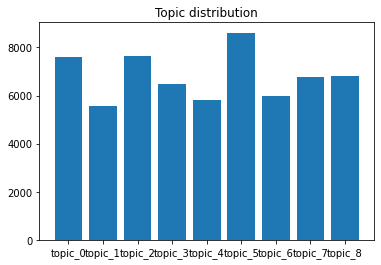

In [36]:
plt.bar(df_topics.columns, df_topics.sum())
plt.title('Topic distribution')
plt.show()

In [125]:
df_dominant_topic.dominant_topic = df_dominant_topic.dominant_topic.astype('int64')
df_dominant_topic.head(3)

,document_no,dominant_topic,percentage_contribution,topic_keywords,text
0,0,5,0.48,"momento, explicacion, aprend, parece, informacion, eleccion, explicado, gran, interesante, interes","[eleccion, hice, tema, explicado, conciso, estructur]"
1,1,8,0.58,"clar, tem, solo, general, bastante, tema, creo, hace, informacion, interesante","[recomendable, profesor, claro, explicacion, sigue, orden, logico, conten]"
2,2,6,0.45,"gusto, aprender, bastante, explica, cada, cosas, instructor, hace, basico, hacer","[instructor, falta, emocionalidad, habl]"


In [126]:
df_dominant_topic.isna().sum()


document_no                0
dominant_topic             0
percentage_contribution    0
topic_keywords             0
text                       0
dtype: int64

,dominant_topic,text
0,5,"[eleccion, hice, tema, explicado, conciso, estructur]"
6,5,"[momento, sido, clar]"
10,5,"[contenido, super, facil, diger]"


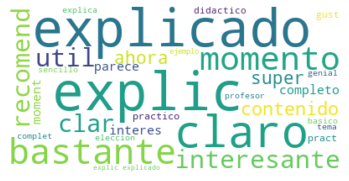

,dominant_topic,text
1,8,"[recomendable, profesor, claro, explicacion, sigue, orden, logico, conten]"
30,8,"[encanto, exelent]"
48,8,"[momento, apenas, segunda, clase, contenido, rico, parte, teorica, espero, practica, igual, genial]"


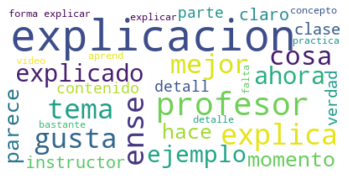

,dominant_topic,text
2,6,"[instructor, falta, emocionalidad, habl]"
12,6,"[experiencia, gratificante, cada, puntos, toman, importantes, lugar, duda, cumplen, objetivos, establec]"
13,6,"[cuenta, recomendaciones, escucha, activa, oradores, sobresalientes, recom]"


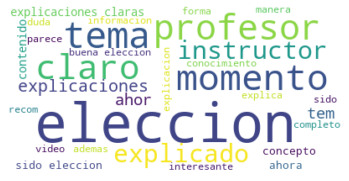

,dominant_topic,text
3,2,"[informacion, valiosa, clara, objet]"
4,2,"[aprendiendo, conceptos, conocia, explicados, forma, clara, facil, comprend]"
7,2,"[claro, mensaje, cada, cl]"


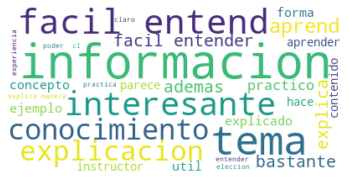

,dominant_topic,text
5,4,"[perfecto, dandole, rasgos, expresion, estudiante, aprendi, entendiendo, agradec]"
18,4,"[solo, larg]"
32,4,"[encantado, realmente, eleccion, profesor, elocuente, gran, soporte, academico, servido, muchisimo, vida, profesional, personal, continuo, practicando, germinara, grandes, frutos, profesor, realizar, salud]"


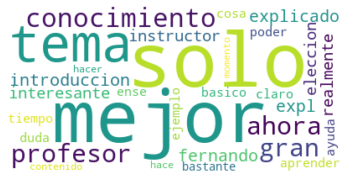

,dominant_topic,text
9,1,"[mejora, tecnicas, estudios, arte, hablar, publ]"
60,1,[encant]
61,1,"[clase, expuesta, explicaciones, sencillas, precision, exactitud, claridad, certez]"


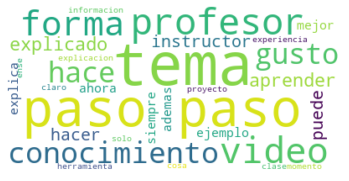

,dominant_topic,text
17,3,"[clases, detalladas, requier]"
20,3,"[interesante, comenzado, teoria, seria, comenzar, caliz, prueba, contundente, aplicacion, tecnicas, sentirse, motiv]"
24,3,"[claro, contenido, videos, cortos, concretos, informacion]"


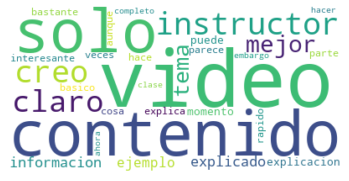

,dominant_topic,text
26,7,"[primero, deja, unas, opciones, luego, probablemente, celul]"
56,7,"[informacion, aplicandola, cuenta, result]"
80,7,"[parece, viendo, cosas, basicas, necesitamos, aprender, comunicarnos, maestro, explica, manera, facil, entend]"


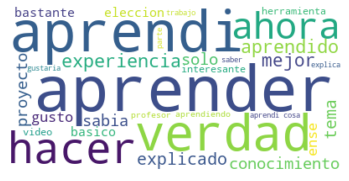

,dominant_topic,text
43,0,"[iniciando, oratoria, herramientas, ejercicios, duda, progres]"
78,0,"[posee, tips, practicas, mejorar, embargo, creo, titulo, enga, basico, medio, avanzado, mast]"
85,0,"[buenos, tips]"


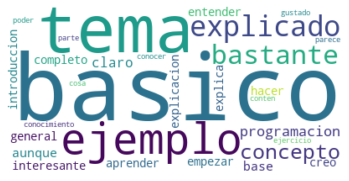

In [39]:
topics = df_dominant_topic.dominant_topic.unique()

for topic in topics:
  df_dominant_filtered = df_dominant_topic[df_dominant_topic.dominant_topic == topic][["dominant_topic","text"]]
  display(df_dominant_filtered.head(3))

  # Join the different processed titles together.
  long_string = ','.join(list([' '.join(map(str, l)) for l in df_dominant_filtered['text']]))
  # Create a WordCloud object
  wordcloud = WordCloud(
      background_color="white",
      max_words=30,
      contour_width=3,
      contour_color='steelblue'
  )
  # Generate a word cloud
  wordcloud.generate(long_string)

  # Visualize the word cloud
  wordcloud.to_image()

  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [127]:
df_dominant_topic.index.size, df_courses_reviews.index.size


(61850, 61850)

In [128]:
df_dominant_topic.dominant_topic.value_counts()

5    9122
0    8211
2    7813
8    6839
7    6752
3    6359
6    5792
4    5547
1    5415
Name: dominant_topic, dtype: int64

In [130]:
headers = ['id', 'course', 'rating', 'comment', 'user', 'mean_rating', 'comment_cleaned', 'tag', 'labels', 'label_confidence']
df_courses_reviews = df_courses_reviews[headers]
df_courses_reviews.reset_index(inplace=True)
df_courses_reviews['labels'] = df_dominant_topic.dominant_topic
df_courses_reviews['label_confidence'] = df_dominant_topic.percentage_contribution

In [131]:
df_courses_reviews.head(3)

,index,id,course,rating,comment,user,mean_rating,comment_cleaned,tag,labels,label_confidence
0,0,95451111,1698124,5.00,"Fue una muy buena elección la que hice. El tema está muy bien explicado, conciso y estructurado.",Leidy Castrillon,4.65,"[eleccion, hice, tema, explicado, conciso, estructur]",pos,5,0.48
1,1,95195366,1698124,5.00,El curso es recomendable. El profesor es claro en la explicación y sigue un orden lógico en el contenido.,Adrian Gillotta,4.65,"[recomendable, profesor, claro, explicacion, sigue, orden, logico, conten]",pos,8,0.58
2,2,94712498,1698124,3.00,Al instructor le falta algo de emocionalidad en el habla,Betsy Anciani,4.65,"[instructor, falta, emocionalidad, habl]",neg,6,0.45


In [132]:
df_courses_reviews.labels.value_counts()


5    9122
0    8211
2    7813
8    6839
7    6752
3    6359
6    5792
4    5547
1    5415
Name: labels, dtype: int64

In [133]:
df_courses_reviews[['comment', 'tag', 'labels']].head(10)

,comment,tag,labels
0,"Fue una muy buena elección la que hice. El tema está muy bien explicado, conciso y estructurado.",pos,5
1,El curso es recomendable. El profesor es claro en la explicación y sigue un orden lógico en el contenido.,pos,8
2,Al instructor le falta algo de emocionalidad en el habla,neg,6
3,"Excelente, información muy valiosa, clara y objetiva",pos,2
4,Porque estoy aprendiendo conceptos que no conocía y que son explicados en forma muy clara y fácil de comprender.,pos,2
5,"perfecto,estoy dandole sentido a algunos rasgos de mi expresión como estudiante que aprendi y con este curso estoy entendiendo más aun con sentido,agradecida.",pos,4
6,Hasta el momento ha sido muy claro.,pos,5
7,Muy claro el mensaje que da cada clase,pos,2
8,"La información que proporciona me parece precisa y correcta conforme al tema, sin embargo esperaba más material. En general me agrado mucho el curso.",pos,2
9,Mejora las tecnicas y estudios sobre el arte de hablar en Publico.,pos,1


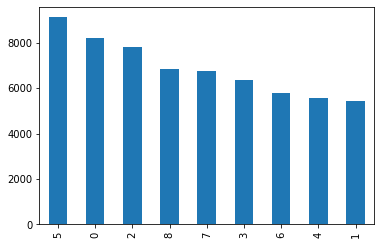

In [134]:
ax = df_dominant_topic.dominant_topic.value_counts().plot(
    kind='bar',
    subplots=True
)
plt.title('')
plt.show()

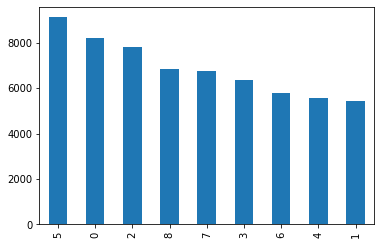

In [135]:
ax = df_courses_reviews.labels.value_counts().plot(
    kind='bar',
    subplots=True
)
plt.title('')
plt.show()

In [136]:
labels = {
    0: 'FELICITACIONES',
    1: 'EXPLICACIONES',
    2: 'EXPECTATICAS',
    3: 'PEDAGOGIA',
    4: 'CONTENIDO',
    5: 'APRENDIZAJE',
    6: 'ELECCION',
    7: 'PROFESORES',
    8: 'ESTRUCTURA',
    'X': None
}

df_courses_reviews['text_labels'] = df_courses_reviews.labels.apply(lambda x: labels[x])
df_courses_reviews.head(3)

,index,id,course,rating,comment,user,mean_rating,comment_cleaned,tag,labels,label_confidence,text_labels
0,0,95451111,1698124,5.00,"Fue una muy buena elección la que hice. El tema está muy bien explicado, conciso y estructurado.",Leidy Castrillon,4.65,"[eleccion, hice, tema, explicado, conciso, estructur]",pos,5,0.48,APRENDIZAJE
1,1,95195366,1698124,5.00,El curso es recomendable. El profesor es claro en la explicación y sigue un orden lógico en el contenido.,Adrian Gillotta,4.65,"[recomendable, profesor, claro, explicacion, sigue, orden, logico, conten]",pos,8,0.58,ESTRUCTURA
2,2,94712498,1698124,3.00,Al instructor le falta algo de emocionalidad en el habla,Betsy Anciani,4.65,"[instructor, falta, emocionalidad, habl]",neg,6,0.45,ELECCION


In [144]:
labels = {
    0: 'felicitaciones',
    1: 'explicaciones',
    2: 'expectativas',
    3: 'pedagogia',
    4: 'contenido',
    5: 'aprendizaje',
    6: 'eleccion',
    7: 'profesores',
    8: 'estructura',
}

df_topics_contribution = pd.DataFrame(corp_list)
df_topics_contribution.rename(columns=labels, inplace=True)
df_topics_contribution.head(3)

,felicitaciones,explicaciones,expectativas,pedagogia,contenido,aprendizaje,eleccion,profesores,estructura
0,0.02,0.02,0.02,0.02,0.02,0.48,0.41,0.02,0.02
1,0.33,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.58
2,0.03,0.03,0.03,0.35,0.03,0.03,0.45,0.03,0.03


In [176]:
headers = ['id', 'course', 'comment', 'user','rating', 'mean_rating', 'comment_cleaned', 'tag', 'labels', 'label_confidence']

df_review_topics_contributions = pd.merge(
    df_courses_reviews[headers],
    df_topics_contribution,
    right_index=True,
    left_index=True
)
df_review_topics_contributions.head(3)

,id,course,comment,user,rating,mean_rating,comment_cleaned,tag,labels,label_confidence,felicitaciones,explicaciones,expectativas,pedagogia,contenido,aprendizaje,eleccion,profesores,estructura
0,95451111,1698124,"Fue una muy buena elección la que hice. El tema está muy bien explicado, conciso y estructurado.",Leidy Castrillon,5.00,4.65,"[eleccion, hice, tema, explicado, conciso, estructur]",pos,5,0.48,0.02,0.02,0.02,0.02,0.02,0.48,0.41,0.02,0.02
1,95195366,1698124,El curso es recomendable. El profesor es claro en la explicación y sigue un orden lógico en el contenido.,Adrian Gillotta,5.00,4.65,"[recomendable, profesor, claro, explicacion, sigue, orden, logico, conten]",pos,8,0.58,0.33,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.58
2,94712498,1698124,Al instructor le falta algo de emocionalidad en el habla,Betsy Anciani,3.00,4.65,"[instructor, falta, emocionalidad, habl]",neg,6,0.45,0.03,0.03,0.03,0.35,0.03,0.03,0.45,0.03,0.03


In [177]:
corr_headers = ['course', 'rating', 'mean_rating', 'felicitaciones', 'explicaciones', 'expectativas', 'pedagogia', 'contenido', 'aprendizaje', 'eleccion', 'profesores', 'estructura' ]
df_corr = df_review_topics_contributions[corr_headers]

df_corr.head(3)

,course,rating,mean_rating,felicitaciones,explicaciones,expectativas,pedagogia,contenido,aprendizaje,eleccion,profesores,estructura
0,1698124,5.00,4.65,0.02,0.02,0.02,0.02,0.02,0.48,0.41,0.02,0.02
1,1698124,5.00,4.65,0.33,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.58
2,1698124,3.00,4.65,0.03,0.03,0.03,0.35,0.03,0.03,0.45,0.03,0.03


In [178]:
course_count = pd.DataFrame(df_corr.course.value_counts().reset_index())
course_count.rename(columns={'index': 'course', 'course': 'count'}, inplace=True)
course_count.head(3)

,course,count
0,1052924,931
1,592918,763
2,976214,735


In [179]:
df_corr = pd.merge(
    df_corr,
    course_count,
    on='course',
    how='inner'
)

df_corr.head(3)

,course,rating,mean_rating,felicitaciones,explicaciones,expectativas,pedagogia,contenido,aprendizaje,eleccion,profesores,estructura,count
0,1698124,5.00,4.65,0.02,0.02,0.02,0.02,0.02,0.48,0.41,0.02,0.02,223
1,1698124,5.00,4.65,0.33,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.58,223
2,1698124,3.00,4.65,0.03,0.03,0.03,0.35,0.03,0.03,0.45,0.03,0.03,223


In [209]:
# Correlation topics to rating
selected_corr = ['rating','mean_rating', 'felicitaciones', 'explicaciones', 'expectativas', 'pedagogia', 'contenido', 'aprendizaje', 'eleccion', 'profesores', 'estructura']
corr = df_corr[selected_corr].corr()
corr

,rating,mean_rating,felicitaciones,explicaciones,expectativas,pedagogia,contenido,aprendizaje,eleccion,profesores,estructura
rating,1.00,0.31,-0.06,-0.02,0.10,-0.27,0.01,0.13,0.04,0.03,0.02
mean_rating,0.31,1.00,-0.06,0.03,0.01,-0.12,0.04,0.04,0.00,0.02,0.03
felicitaciones,-0.06,-0.06,1.00,-0.12,-0.15,-0.13,-0.13,-0.16,-0.13,-0.13,-0.14
explicaciones,-0.02,0.03,-0.12,1.00,-0.12,-0.10,-0.10,-0.13,-0.11,-0.11,-0.12
expectativas,0.10,0.01,-0.15,-0.12,1.00,-0.14,-0.12,-0.15,-0.12,-0.14,-0.14
pedagogia,-0.27,-0.12,-0.13,-0.10,-0.14,1.00,-0.11,-0.14,-0.11,-0.12,-0.11
contenido,0.01,0.04,-0.13,-0.10,-0.12,-0.11,1.00,-0.13,-0.10,-0.11,-0.11
aprendizaje,0.13,0.04,-0.16,-0.13,-0.15,-0.14,-0.13,1.00,-0.11,-0.15,-0.13
eleccion,0.04,0.00,-0.13,-0.11,-0.12,-0.11,-0.10,-0.11,1.00,-0.11,-0.11
profesores,0.03,0.02,-0.13,-0.11,-0.14,-0.12,-0.11,-0.15,-0.11,1.00,-0.13


<AxesSubplot:>

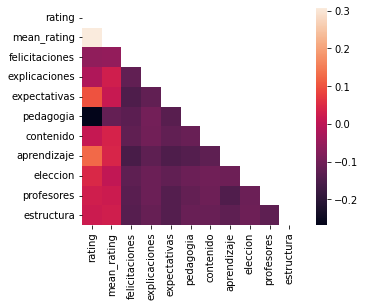

In [214]:
import seaborn as sns

# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, square=True)

In [162]:
df_corr.groupby('course').mean().head(10)

,mean_rating,felicitaciones,explicaciones,expectativas,pedagogia,contenido,aprendizaje,eleccion,profesores,estructura,count
course,,,,,,,,,,,
78104,4.43,0.12,0.07,0.20,0.12,0.12,0.12,0.09,0.09,0.07,444.00
81450,4.48,0.16,0.07,0.11,0.11,0.09,0.14,0.11,0.10,0.11,188.00
97280,4.71,0.08,0.08,0.19,0.07,0.08,0.12,0.14,0.11,0.10,428.00
101866,4.56,0.19,0.07,0.11,0.09,0.07,0.16,0.09,0.09,0.12,388.00
120058,4.17,0.12,0.08,0.10,0.18,0.09,0.14,0.11,0.06,0.11,404.00
130838,4.46,0.15,0.12,0.12,0.13,0.10,0.12,0.09,0.09,0.09,244.00
137590,4.43,0.20,0.08,0.11,0.12,0.08,0.14,0.07,0.09,0.12,209.00
162972,4.57,0.13,0.06,0.13,0.09,0.05,0.16,0.10,0.16,0.11,241.00
182682,4.59,0.11,0.08,0.14,0.10,0.05,0.18,0.08,0.13,0.12,544.00


In [183]:
rating_count = pd.DataFrame(df_corr.rating.value_counts().reset_index())
rating_count.rename(columns={'index': 'rating', 'rating': 'count'}, inplace=True)
rating_count

,rating,count
0,5.00,37478
1,4.00,8472
2,4.50,8330
3,3.50,2733
4,3.00,2508
5,1.00,812
6,2.50,763
7,2.00,485
8,1.50,228
9,0.50,41


In [206]:
def distr_normalizada(df, rating_count, topic_col: str, threshold = 0.2):
    rating_cantidad_ti = df.loc[df[topic_col] > threshold, ['rating', 'course']].groupby("rating").count()['course'].reset_index()
    rating_cantidad_ti.rename(columns={'course': 'index'}, inplace=True)
    rating_cantidad_ti = rating_cantidad_ti.merge(rating_count)
    rating_cantidad_ti['cantidad_normalizada'] = rating_cantidad_ti['index'] / rating_cantidad_ti['count']
    rating_cantidad_ti['cantidad_normalizada2'] = rating_cantidad_ti['cantidad_normalizada'] / rating_cantidad_ti['cantidad_normalizada'].sum()
    plt.axhline(np.mean(rating_cantidad_ti.cantidad_normalizada2), linestyle='--', color = 'red')
    plt.bar(rating_cantidad_ti.rating, rating_cantidad_ti.cantidad_normalizada2, width=0.45)
    plt.xlabel('Rating')
    plt.ylabel('Proporción Normalizada')
    plt.title(f'Distribucion normalizada para el topico {topic_col}')
    plt.show()

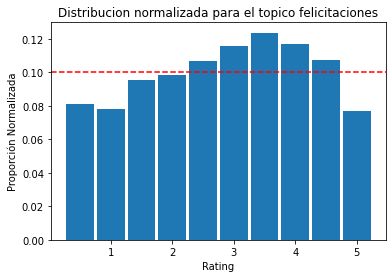

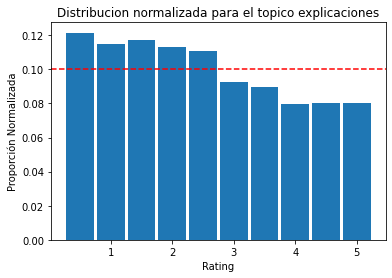

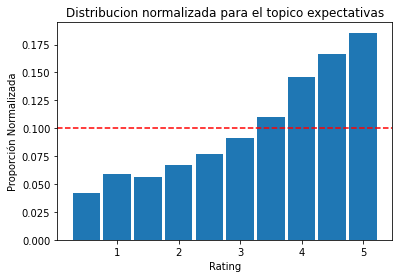

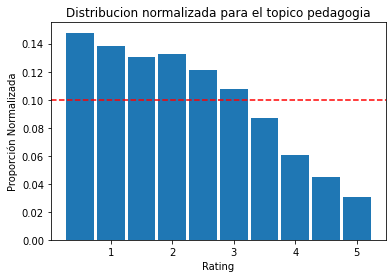

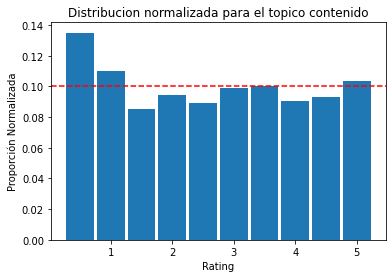

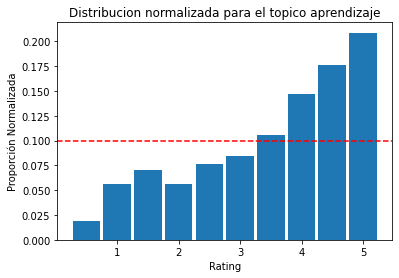

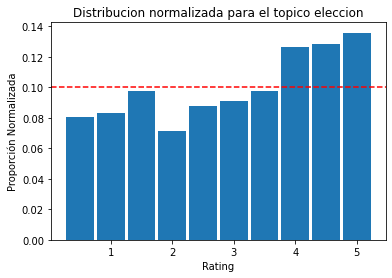

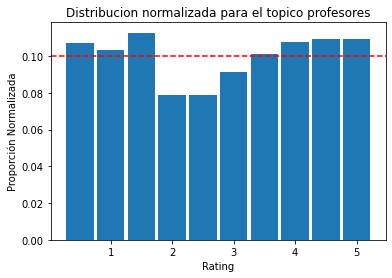

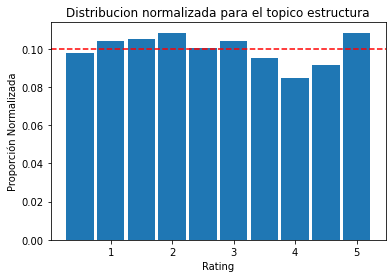

In [207]:
topics = ['felicitaciones', 'explicaciones', 'expectativas', 'pedagogia', 'contenido', 'aprendizaje', 'eleccion', 'profesores', 'estructura']

for topic in topics:

    distr_normalizada(
        df=df_corr,
        rating_count=rating_count,
        topic_col=topic
    )

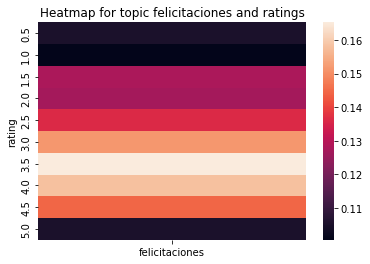

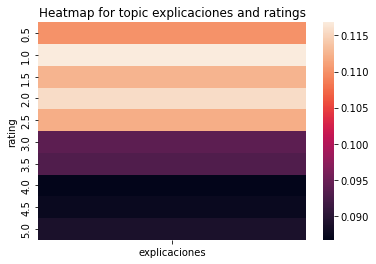

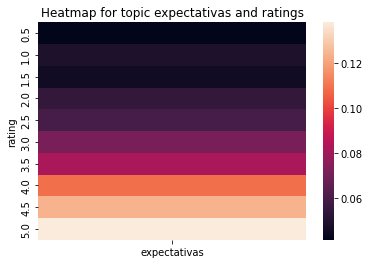

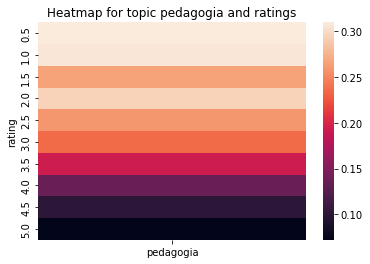

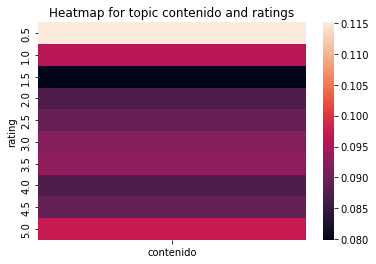

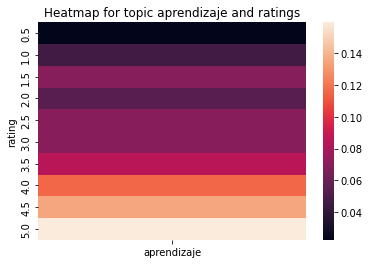

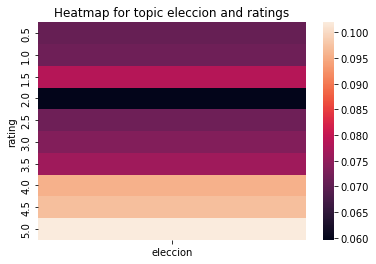

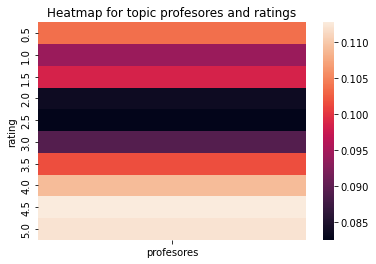

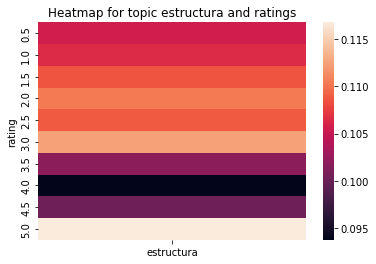

In [277]:
import seaborn as sns
topics = ['felicitaciones', 'explicaciones', 'expectativas', 'pedagogia', 'contenido', 'aprendizaje', 'eleccion', 'profesores', 'estructura']

for topic in topics:
    df_heat = df_corr[['rating', topic]]
    df_heat = df_heat.groupby('rating').mean().reset_index()
    df_heat = df_heat.set_index('rating')
    sns.heatmap(df_heat)
    plt.title(f'Heatmap for topic {topic} and ratings')
    plt.show()


In [238]:
def _run_regression(df):
    import statsmodels.api as sm

    #separate the other attributes from the predicting attribute
    x = df.drop(['course', 'rating'], axis=1)

    #separte the predicting attribute into Y for model training
    y = df['rating']

    x2 = sm.add_constant(x)
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(est2.summary())

In [239]:
_run_regression(df_corr)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     1133.
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:31:35   Log-Likelihood:                -67473.
No. Observations:               61850   AIC:                         1.350e+05
Df Residuals:                   61838   BIC:                         1.351e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.2073      0.172     -7.

In [240]:
regression_headers = ['course', 'count', 'rating', 'felicitaciones', 'explicaciones', 'expectativas', 'pedagogia', 'contenido', 'aprendizaje', 'eleccion', 'profesores', 'estructura' ]
df_regression = df_corr[regression_headers].groupby('course').mean().reset_index()
df_regression

,course,count,rating,felicitaciones,explicaciones,expectativas,pedagogia,contenido,aprendizaje,eleccion,profesores,estructura
0,78104,444.00,4.42,0.12,0.07,0.20,0.12,0.12,0.12,0.09,0.09,0.07
1,81450,188.00,4.42,0.16,0.07,0.11,0.11,0.09,0.14,0.11,0.10,0.11
2,97280,428.00,4.70,0.08,0.08,0.19,0.07,0.08,0.12,0.14,0.11,0.10
3,101866,388.00,4.51,0.19,0.07,0.11,0.09,0.07,0.16,0.09,0.09,0.12
4,120058,404.00,4.08,0.12,0.08,0.10,0.18,0.09,0.14,0.11,0.06,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...
174,2915362,547.00,4.72,0.06,0.08,0.08,0.07,0.08,0.17,0.12,0.20,0.13
175,3013160,223.00,4.83,0.12,0.11,0.09,0.07,0.08,0.13,0.12,0.17,0.10
176,3372986,198.00,4.94,0.06,0.11,0.04,0.07,0.29,0.14,0.09,0.08,0.11
177,3446356,312.00,4.54,0.09,0.11,0.10,0.11,0.06,0.13,0.09,0.11,0.19


In [241]:
_run_regression(df_regression)


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     33.49
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           4.70e-35
Time:                        12:31:35   Log-Likelihood:                 85.717
No. Observations:                 179   AIC:                            -149.4
Df Residuals:                     168   BIC:                            -114.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.4305      4.911      3.

In [258]:
THRESHOLD = 0.2

regression_headers = ['course', 'count', 'rating', 'felicitaciones', 'explicaciones', 'expectativas', 'pedagogia', 'contenido', 'aprendizaje', 'eleccion', 'profesores', 'estructura' ]
df_regression = df_corr[regression_headers]

for topic in topics:
    df_regression[topic] = df_regression[topic].apply(lambda x: 1 if x > THRESHOLD else 0)

df_course_rating = df_regression[regression_headers].groupby('course').mean().reset_index()
df_course_rating = df_course_rating[['course', 'rating', 'count']]
df_course_topic = df_regression[regression_headers].groupby('course').sum().reset_index()
df_course_topic = df_course_topic.drop('rating', axis=1)
df_course_topic = df_course_topic.drop('count', axis=1)

df_regression = pd.merge(
    df_course_rating,
    df_course_topic,
    on='course',
    how='inner'
)

df_regression

,course,rating,count,felicitaciones,explicaciones,expectativas,pedagogia,contenido,aprendizaje,eleccion,profesores,estructura
0,78104,4.42,444.00,82,43,135,78,82,90,53,58,47
1,81450,4.42,188.00,45,13,33,26,22,42,32,27,34
2,97280,4.70,428.00,54,49,137,57,57,90,103,74,67
3,101866,4.51,388.00,112,36,63,49,37,100,61,52,70
4,120058,4.08,404.00,76,48,66,115,56,92,72,37,70
...,...,...,...,...,...,...,...,...,...,...,...,...
174,2915362,4.72,547.00,42,61,67,59,65,145,110,172,123
175,3013160,4.83,223.00,43,41,33,27,29,49,48,61,35
176,3372986,4.94,198.00,15,35,12,22,93,46,26,22,37
177,3446356,4.54,312.00,51,51,50,54,30,68,50,50,94


In [259]:
_run_regression(df_regression)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     22.29
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           3.98e-26
Time:                        12:52:33   Log-Likelihood:                 63.168
No. Observations:                 179   AIC:                            -104.3
Df Residuals:                     168   BIC:                            -69.27
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.4418      0.040    110.